<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>
    ДИСЦИПЛИНА <br>
        «Модели и методы обработки статистической информации в автоматизированном управлении НГО»
    <br><br> <br> <br> <br> <br> <br><br>
    ОТЧЁТ <br>
    по лабораторной работе №4 <br>
    «Регрессионный анализ»<br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br><br>  <br> <br> <br> <br> <br> <br><br>
</p>

<p style="text-align: right;">
    Выполнил: студент группы АС-21-05, Негробов В.А.<br>
    Проверила: старший преподаватель, Степанкина О.А.<br><br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br> <br> <br><br><br> <br> <br> <br> <br><br>
</p>

<p style="text-align: center;">
    МОСКВА 2024
</p>

----------------------------------------------------------------------------------------
<br><br>Вариант 14 (2)
По данным предыдущей работы провести регрессионный анализ:

1. выбрать вид регрессионной зависимости (возможно преобразование данных для выбора линейной модели); 
2. определить модельные коэффициенты;
3. проверить модель на значимость;
4. провести проверку модели на адекватность (см. дополнительные данные на отдельной вкладке). 

Подключение используемых библиотек и стиля отображаемых графиков:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from itertools import chain
from scipy.stats import spearmanr, f

plt.style.use('ggplot')

C:\Users\vikto\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\vikto\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Считывание данных:

In [2]:
names = [f'var{i + 1}' for i in range(5)]

df_train = pd.read_excel('ms-data2-2022.xlsx', sheet_name='2-2',
                   header=None, names=names)
df_train.head()

,var1,var2,var3,var4,var5
0,4.519,7.698,23.751,18.929,10.421
1,1.880,5.603,0.274,3.846,4.352
2,3.543,5.828,15.930,5.631,6.402
3,3.407,6.534,14.081,4.395,10.098
4,3.102,6.398,15.516,9.742,3.777


In [3]:
df_test = pd.read_excel('ms-data2-2022.xlsx', sheet_name='2вар-адекв',
                   header=None, names=names)
df_test.head()

,var1,var2,var3,var4,var5
0,-1,4.266,-13.086,1.679,0.935
1,-1,5.272,-18.273,1.039,1.083
2,-1,3.455,-20.921,0.532,1.504
3,-1,5.814,-20.201,0.957,1.748
4,-1,4.951,-17.377,2.967,2.407


Тренировочные и тестовые данные:

In [4]:
independent_var = 'var1'

y_train = df_train[[var for var in df_train.columns if var != independent_var]]
x_train = df_train[independent_var]
y_test = df_test[y_train.columns]
x_test = df_test[independent_var]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60,), (60, 4), (30,), (30, 4))

# Выбор регрессионного вида зависимости

In [5]:
def plot_data(x, y):
    fig, axs = plt.subplots(y.shape[1]//2, y.shape[1]//2, figsize=(10, 10))

    axs = list(chain.from_iterable(axs))

    for name, ax in zip(y_train.columns, axs):
        res = spearmanr(x, y[name])
        sns.regplot(x=x, y=y[name], ax=ax)
        ax.set_ylabel(name)
        ax.set_xlabel(independent_var)
        ax.text(x.min(), y[name].max(), 
                f'corr: {res[0]:.2f}, p-val: {res[1]:.2f}')

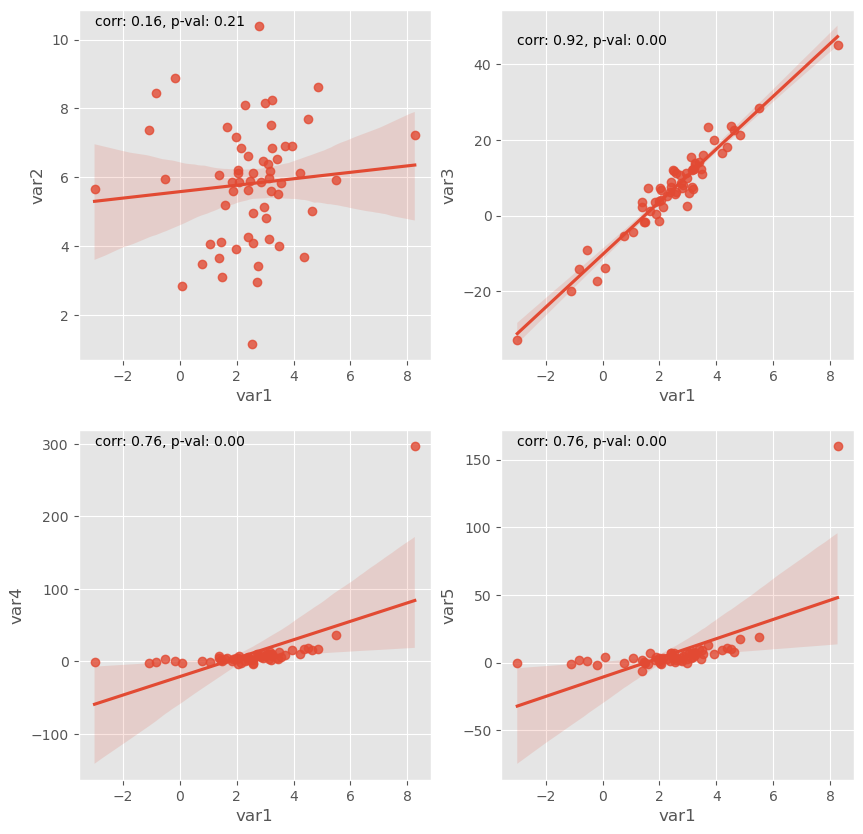

In [6]:
plot_data(x_train, y_train)

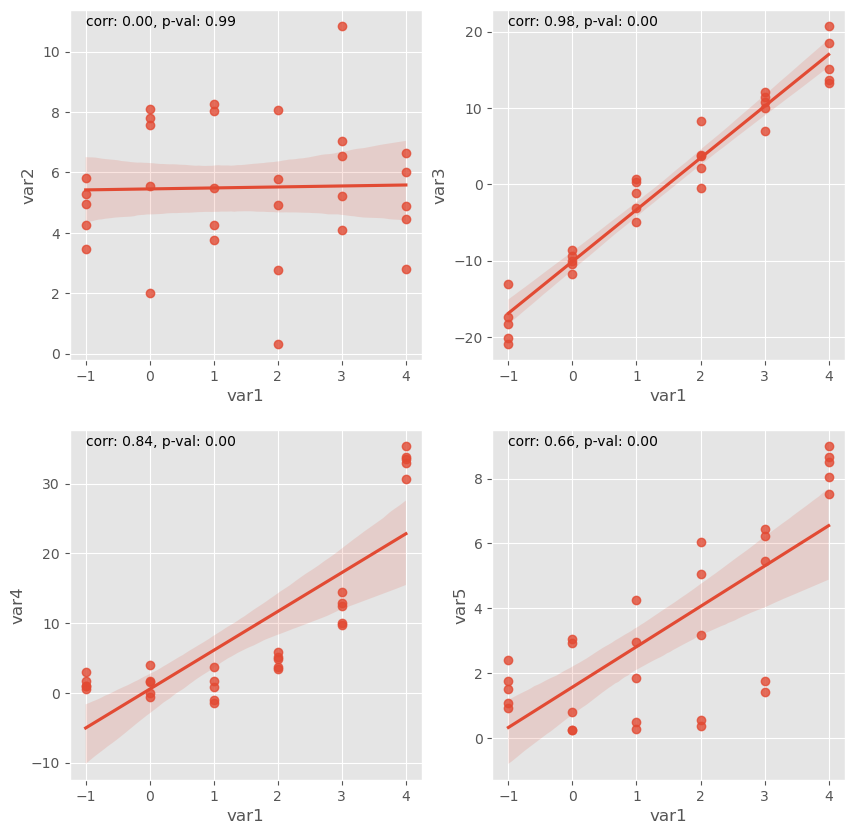

In [7]:
plot_data(x_test, y_test)

var1 - var2 - независимые

var1 - var3 - линейная зависимость

var1 - var4 - экспоненциальная зависимость

var1 - var5 - экспоненциальная зависимость


С целью преобразования экспоненциальная зависимости в линейную, выполним преобразование: $y' = log(1 + y - min)$

где min = min(y),

In [8]:
var4_min = y_train['var4'].min()
var5_min = y_train['var5'].min()
y_train.loc[:, 'var4'] = np.log(0.01 + y_train['var4'] - var4_min).values
y_train.loc[:, 'var5'] = np.log(0.01 + y_train['var5'] - var5_min).values
y_test.loc[:, 'var4'] = np.log(0.01 + y_test['var4'] - var4_min).values
y_test.loc[:, 'var5'] = np.log(0.01 + y_test['var5'] - var5_min).values

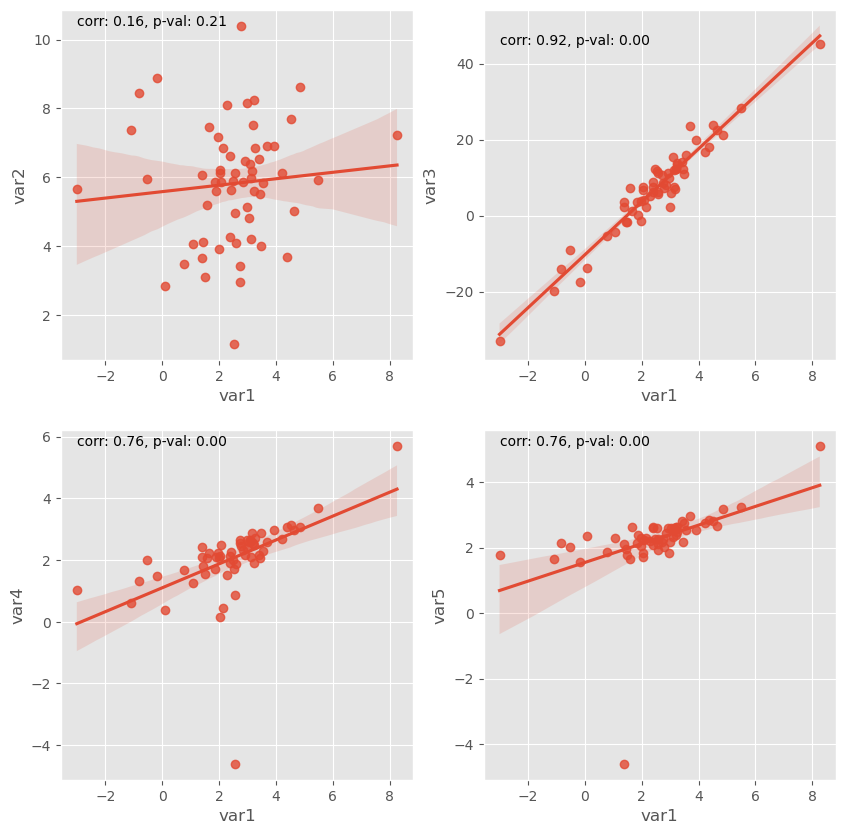

In [9]:
plot_data(x_train, y_train)

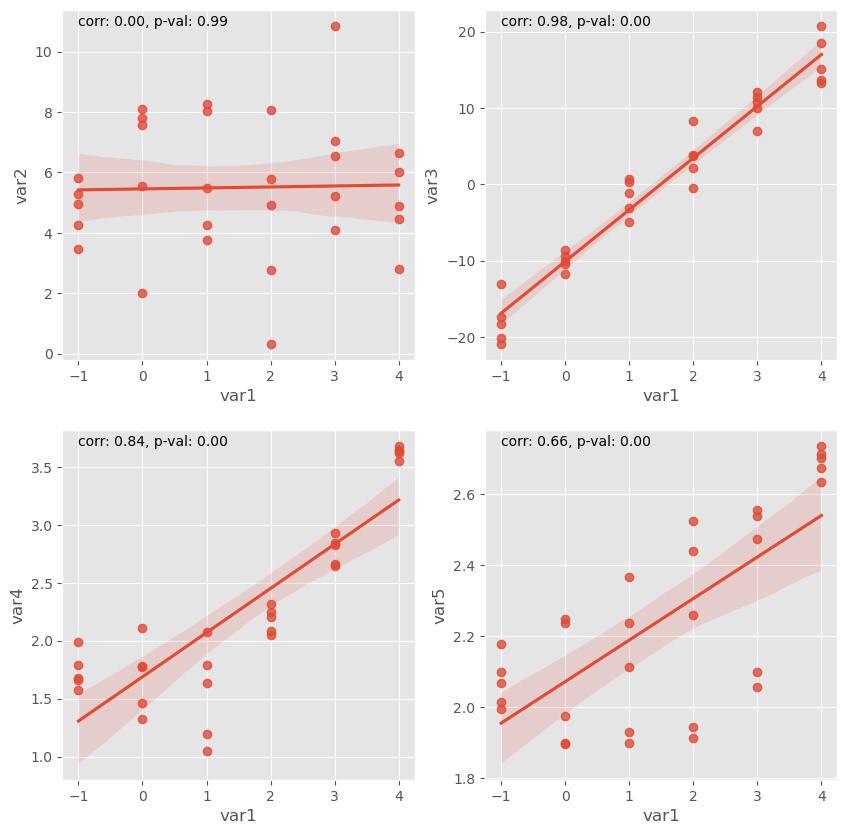

In [10]:
plot_data(x_test, y_test)

# Определить модельные коэффициенты; проверить модель на значимость; провести проверку модели на адекватность

Функция, выполняющая проверку на значимость

In [11]:
def get_means(x_test, y_test):
    means = dict()
    for x in x_test.unique():
        means[x] = np.mean(y_test[x_test == x])
    
    def f(x):
        nonlocal means, x_test
        return means[x], (x_test == x).sum()
    return f

In [12]:
def is_adequately(linear_model, x_test, y_test):
    n = 30
    m = 6
    f_means = get_means(x_test, y_test)
    x_test_unique = x_test.unique()
    preds = linear_model.predict(pd.Series(x_test_unique, name='var1'))
    Q2 = 0
    for x, pred in zip(x_test_unique, preds):
        mean, n_i = f_means(x)
        Q2 += n_i * (mean - pred) ** 2

    Q3 = 0
    mean = y_test_part.mean()
    for y in y_test_part:
        Q3 += (mean - y) ** 2

    t = Q2 * (n - m) / (Q3 * (m - 2))
    tcr = f.ppf(0.95, m-2, n-m)
    
    print(f'{t = :.2f}, {tcr = :.2f}')

    return t < tcr

1-2

In [13]:
target_var = 'var2'
y_test_part = y_test[target_var]

model_linear_ols = smf.ols(formula=f'{target_var} ~ var1', data=df_train)
linear_model = model_linear_ols.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.4814
Date:                Mon, 13 May 2024   Prob (F-statistic):              0.491
Time:                        10:50:03   Log-Likelihood:                -117.04
No. Observations:                  60   AIC:                             238.1
Df Residuals:                      58   BIC:                             242.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5817      0.404     13.818      0.000       4.773       6.390
var1           0.0936      0.135      0.694      0.491      -0.176       0.363
==============================================================================
Omnibus:                        0.555   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.116
Skew:                          -0.019   Prob(JB):                        0.944
Kurtosis:                       3.212   Cond. No.                         5.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
is_adequately(linear_model, x_test, y_test_part)

t = 1.02, tcr = 2.78


True

Нельзя отвергнуть гипотезу о незначимости модели, коэффициенты: $b = 5.58, k = 0.09$, модель адекватна

1-3

In [15]:
target_var = 'var3'
y_test_part = y_test[target_var]

model_linear_ols = smf.ols(formula=f'{target_var} ~ var1', data=df_train)
linear_model = model_linear_ols.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var3   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     819.6
Date:                Mon, 13 May 2024   Prob (F-statistic):           6.55e-36
Time:                        10:50:03   Log-Likelihood:                -152.47
No. Observations:                  60   AIC:                             308.9
Df Residuals:                      58   BIC:                             313.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.2995      0.729    -14.127      0.000     -11.759      -8.840
var1           6.9670      0.243     28.629      0.000       6.480       7.454
==============================================================================
Omnibus:                        0.474   Durbin-Watson:                   2.485
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.109
Skew:                           0.075   Prob(JB):                        0.947
Kurtosis:                       3.145   Cond. No.                         5.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
is_adequately(linear_model, x_test, y_test_part)

t = 0.04, tcr = 2.78


True

Модель значима, коэффициенты: $b = -10.30, k = 6.68$, модель адекватна

1-4

In [17]:
target_var = 'var4'
y_test_part = y_test[target_var]

model_linear_ols = smf.ols(formula=f'{target_var} ~ var1', data=df_train)
linear_model = model_linear_ols.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var4   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     25.85
Date:                Mon, 13 May 2024   Prob (F-statistic):           4.14e-06
Time:                        10:50:03   Log-Likelihood:                -292.28
No. Observations:                  60   AIC:                             588.6
Df Residuals:                      58   BIC:                             592.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.0469      7.495     -2.808      0.007     -36.050      -6.044
var1          12.7193      2.502      5.084      0.000       7.711      17.727
==============================================================================
Omnibus:                      104.640   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2885.365
Skew:                           5.279   Prob(JB):                         0.00
Kurtosis:                      35.290   Cond. No.                         5.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
is_adequately(linear_model, x_test, y_test_part)

t = 4733.66, tcr = 2.78


False

Модель значима, коэффициенты: $b = -21.05, k = 12.72$, модель неадекватна

1-5

In [19]:
target_var = 'var5'
y_test_part = y_test[target_var]

model_linear_ols = smf.ols(formula=f'{target_var} ~ var1', data=df_train)
linear_model = model_linear_ols.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var5   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     28.77
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.48e-06
Time:                        10:50:04   Log-Likelihood:                -254.13
No. Observations:                  60   AIC:                             512.3
Df Residuals:                      58   BIC:                             516.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.7114      3.968     -2.699      0.009     -18.655      -2.768
var1           7.1052      1.325      5.364      0.000       4.454       9.757
==============================================================================
Omnibus:                      103.082   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2702.774
Skew:                           5.173   Prob(JB):                         0.00
Kurtosis:                      34.210   Cond. No.                         5.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
is_adequately(linear_model, x_test, y_test_part)

t = 11301.79, tcr = 2.78


False

Модель значима, коэффициенты: $b=−10.71, k=7.11$, модель неадекватна